In [1]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import itertools
import serie2GAF
import pickle
import learn_utils
import meta_features as mf
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import butter, lfilter, filtfilt
from tabulate import tabulate
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from detect_peaks import detect_peaks
from gaussian_kde import gaussian_kde
from sklearn.neighbors import KernelDensity
from operator import itemgetter
from sklearn.externals import joblib
from time import time

import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

## Data description

The features selected for this dataset come from the accelerometer and gyroscope 3-axial raw signals tAcc-XYZ and tGyro-XYZ. That signal was taken using the <a href=http://playground.arduino.cc/Main/MPU-6050> InvenSense MPU-6050 </a> sensor, which contains a MEMS accelerometer and a MEMS gyro in a single chip. The sensor possess a 16-bits analog to digital conversion hardware for each channel. Therefor it captures the x, y, and z channel at the same time. The sensor was used with the I2C-bus to interface with an Arduino attached to the player.  We also use a Microsoft Kinect 2 sensor in order to get 3 additional features: Contraction Index (CI), distance, proximity. This last feature is a normalized - [0,1] interval - version of distance. Thus, they shall be used in mutually exclusion. The normalization is done by limiting the distance to 4.5 meters, the known stable limit of the sensor. So, the player has a greater proximity value when it is seen close to the robot. The value tends to zero otherwise. Ideally, the CI feature correspond to how open-wide (in terms of legs and arms) the player is.

## Support functions

WARNING: If "too many valus to unpack" error in the getCSV method, restart the kernel. Something must bust be wrong with the kernel initialization. Must be checked (LOW-PRIORITY).

### Load

In [137]:
def loadFile(file_name, directory, ignore_col_list = ['/ext_usb_camera/image/compressed', 'robogame/imu_state'],
             verbose=False):
    
    csv_data = None          # the variable where the loaded csv data is stored.
    num_windows = 0          # the number of windows loaded.
    windows = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    #print '-- Processing: "{}"'.format(file_name)

    # load the data, abort in case of error.
    try:
        num_windows, csv_data = getCSV(os.path.join(directory, file_name))
    except ValueError as e:
        print traceback.format_exc()
        sys.exit(-1)

    for w in range(num_windows):
        win_data = {}
        for k in csv_data.keys():
            # consider the data only if it is not in the ignore list.
            if k not in ignore_col_list:
                if  csv_data[k][w] == []:
                    raise ValueError("\tFile has empty tagged windows. Skipping...")
                win_data[feature_name_map[k]] = csv_data[k][w]
                
        # convert dictionary to dataframe and save it to list of all windows data for the file.
        windows.append(pd.DataFrame.from_dict(win_data))
    
    #print '-- Retrieved {} windows in {}'.format(num_windows, file_name)
    
    if verbose:
        overlap_reference = 50
        try:
            _, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)
            print "LOAD SUMMARY:"
            print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                               headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])
        except ValueError as e:
            print traceback.format_exc()
            return None
    return windows


def get_human_sim_matrix(csvfile, low_sim_value=0, high_sim_value=5):
    """ Given a csv file in the form
        
        video1 , video2 , avg_similarity
          ...  ,  ...   ,     ...
          
        , this functions reconstructs a matrix of similarity
        
      params
          csvfile : the csv
          low_sim_value : the lowest possible rating given
          high_sim_value: the highest possible rating given
      
      returns
          video1  : the list of names for video1
          video2  : the list of names for video2
          matrix  : the similarity matrix.
          
      use video1 and video2 to translate the indexes of the matrix into their names.
    """

    df = pd.read_csv(csvfile, index_col=False, header=0);
    
    video1 = tuple(set(df["VIDEO 1"]))    # list of name for video 1
    video2 = tuple(set(df["VIDEO 2"]))    # list of name for video 2

    dt = pd.DataFrame({'v1_index': range(len(video1))})
    dt = dt.set_index('v1_index')

    for vname in range(len(video2)):
        dt[vname] = ""

    #print list(dt.index)

    for index, row in df.iterrows():
        dt.at[video1.index(row["VIDEO 1"]),
              video2.index(row["VIDEO 2"])] = serie2GAF.translateIntervalRange(row["AVG_SIMILARITY"],
                                                                               low_sim_value,
                                                                               high_sim_value,
                                                                               0,
                                                                               1)

    # testing if it is correct
    for index, row in df.iterrows():
        assert serie2GAF.translateIntervalRange(dt.at[video1.index(row["VIDEO 1"]),
                                                      video2.index(row["VIDEO 2"])], 0,1,low_sim_value,high_sim_value) == row["AVG_SIMILARITY"]
    return video1, video2, dt

##### Get the list of files and also the list of files with last video segment less than 15secs #####
def get_human_norm_sim_matrix(docs_names, docs, csvfile='.pickle/table_1.csv'):
    import json
    from collections import defaultdict
    d = defaultdict(int)
    f = open('fileidwebsite.txt','r')
    flen = open('length.txt','r')


    ### Get the filenames that have the last segment less than 15secs.
    remove_one_list = []
    for i in flen.readlines():
        s = i.split(' ')
        if float(s[-1]) < 15.00:
            #print s[0]
            remove_one_list.append( '_'+"_".join(s[0].split("_")[1:-1])+'_Player.csv')
    remove_one_list = list(set(remove_one_list))
    print "Filenames with less than 15secs in the last window:\n{}".format(remove_one_list)


    for i in f.readlines():
        #print i.strip()
        #recovering the original name
        if i != "\n":
            d["_"+"_".join(i.split("_")[1:-1])+'_Player.csv'] += 1

    ##### Checking segments and removing the anomalies #####

    websiteids = dict(d)

    for k in websiteids.keys():   
        if k not in partition_book_list.keys():
            del websiteids[k]
    for k in websiteids.keys():
        if k in remove_one_list:
            websiteids[k] -= 1

    ### Assert equality on the segment number
    for i, k in enumerate(websiteids.keys()):
        try:
            assert websiteids[k] == partition_book_list[k]
        except Exception as e:
            print "Failed assertion in {}!".format(k)

    #print "websiteids (#{} files):".format(len(websiteids))
    #print json.dumps(dict(websiteids), indent=4)
    #print "partition (#{} files):".format(len(partition_book_list))
    #print json.dumps(partition_book_list, indent=4)

    ##### FILTERING THE ALLOWED NAMES #####

    allowed_name_list_v1 = []       ## list of files to get the MSE 
    allowed_name_list_v2 = []       ## list of files to get the MSE

    website_dataframe = pd.read_csv(csvfile, index_col=False, header=0);

    list_namesv1 = tuple(set(website_dataframe["VIDEO 1"]))    # list of name for video 1
    list_namesv2 = tuple(set(website_dataframe["VIDEO 2"]))    # list of name for video 2

    prepro = list(list_namesv1)
    prepro.remove('_2016-11-26-16-35-21_exp1d.mp4')
    prepro.remove('_2016-11-26-16-05-47_exp1d.mp4')

    list_namesv1 = tuple(prepro)

    prepro = list(list_namesv2)
    prepro.remove('_2016-11-24-17-40-06_expb.mp4')
    prepro.remove('_2016-11-24-16-23-29_expc.mp4')

    list_namesv2 = tuple(prepro)

    for n in list_namesv1:
        if float(n.split('.')[0].split('_')[-1]) < partition_book_list["_".join(n.split('.')[0].split('_')[:-1])+'_Player.csv']:
            allowed_name_list_v1.append(n)

    for n in list_namesv2:
        if float(n.split('.')[0].split('_')[-1]) < partition_book_list["_".join(n.split('.')[0].split('_')[:-1])+'_Player.csv']:
            allowed_name_list_v2.append(n)


    #print allowed_name_list_v1
    #print allowed_name_list_v2

    ##### Testing the file existence in the docs and test name list #####

    for n in allowed_name_list_v1:
        assert n in docs_names

    for n in allowed_name_list_v2:
        assert n in docs_names

    print "File docs and website docs matching result: OK"

    ##### GET MATRIX ###

    low_sim_value = 0
    high_sim_value = 5

    m = np.array([[0.0 for i in range(len(docs))] for j in range(len(docs))])

    for index, row in website_dataframe.iterrows():
        if row["VIDEO 1"] in allowed_name_list_v1 and row["VIDEO 2"] in allowed_name_list_v2:
            m[docs_names.index(row["VIDEO 1"])][docs_names.index(row["VIDEO 2"])] = serie2GAF.translateIntervalRange(row["AVG_SIMILARITY"],
                                                                                       low_sim_value,
                                                                                       high_sim_value,
                                                                                       0,                                                                                   1)
    for r in range(m.shape[0]):
        m[r][r] = 1.0     ## a file is 100% similar to itself.

    return m

### Filtering

In [3]:
def runningMean(l, N):
    # Also works for the(strictly invalid) cases when N is even.
    if (N//2)*2 == N:
        N = N - 1
    front = np.zeros(N//2)
    back = np.zeros(N//2)

    for i in range(1, (N//2)*2, 2):
        front[i//2] = np.convolve(l[:i], np.ones((i,))/i, mode = 'valid')
    for i in range(1, (N//2)*2, 2):
        back[i//2] = np.convolve(l[-i:], np.ones((i,))/i, mode = 'valid')
    return np.concatenate([front, np.convolve(l, np.ones((N,))/N, mode = 'valid'), back[::-1]])

def computeRunMeanAcc(data, showPlot= False, suptitle="Running average smoothing", feature='activity', N=4):
    """Running average as smoothing"""
    

    ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
    # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
    norm_dataX = running_mean(data, N)
    
    if showPlot:
        fig, ax = plt.subplots(1,1, figsize=(18,8))
        N_samps = len(norm_dataX)
        Fs = N_samps/time_interval
        print "Time interval: ", str(time_interval)
        # the period represents the oscilation. It's  the sample time, the time after which each data come.
        T = 1./Fs
        print "Period: {}".format(T)

        t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.

        ax.set_ylabel('g\'s (9.8 m/s^2)')
        ax.plot(norm_dataX)
        ax.grid()
        #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)

        plt.draw()
    
    return norm_dataX

In [4]:
def moving_rmsV1(x, window):
    """Moving RMS of 'x' with window size 'window'."""
    window = 2*window + 1
    return np.sqrt(np.convolve(x*x, np.ones(window)/window, 'same'))

### Computing

In [123]:
def get_mse(X, Y):
    """Returns Mean of Square error for two input matrix."""
    return ((Kxy - m) ** 2).mean(axis=None)

### Processing

In [5]:
def processFiles(listOfFiles, directory, plot_signal=False):
    failed_files = []
    
    acc_frequences = []
    ciprox_frequences = []
    datasetX = []
    datasetY = []
    datasetZ = []
    datasetCI = []
    datasetProximity = []

    for f in listOfFiles:
        csv_filename = f
        file_data = []             # the list of windows data. Each element is a pandas dataframe 
                                   #  corresponding to the windows. The list is of size 'num_windows'.

        #print 'Processing: "{}"'.format(csv_filename)

        # load the data, abort in case of error.
        try:
            file_data = loadFile(csv_filename, directory)
        except ValueError as e:
            #print traceback.format_exc()
            failed_files.append(csv_filename)
            continue

        #### Normalize to g's accelerometer axis ####
        allAccX = []
        allAccY = []
        allAccZ = []
        allCi   = []
        allProximity = []
        time_interval = 0
        
        #print '-- Normalizing accelerometer data...'
        for i, w in enumerate(file_data):
            if i==0:
                time_interval = w['time'].iloc[-1]
                for x, y, z in zip(w['accX'].dropna().as_matrix(),
                                   w['accY'].dropna().as_matrix(),
                                   w['accZ'].dropna().as_matrix()):
                    
                    allAccX.append(x/16384.0)
                    allAccY.append(y/16384.0)
                    allAccZ.append(z/16384.0)
                
                for c, p in zip(w['ci'].dropna().as_matrix(),
                                w['proximity'].dropna().as_matrix()):
                    if c > 1:
                        allCi.append(1)
                    else:
                        allCi.append(c)
                    if p > 1:
                        allProximity.append(1)
                    else:
                        allProximity.append(p)
                    
            else:
                values = list(set(w['time']) - set(file_data[i-1]['time']))
                time_interval = w['time'].iloc[-1]
                result = w[w['time'].isin(values)]
                for x, y, z in zip(result['accX'].dropna().as_matrix(),
                                   result['accY'].dropna().as_matrix(),
                                   result['accZ'].dropna().as_matrix()):
                    
                    allAccX.append(x/16384.0)
                    allAccY.append(y/16384.0)
                    allAccZ.append(z/16384.0)
                
                for c, p in zip(w['ci'].dropna().as_matrix(),
                                w['proximity'].dropna().as_matrix()):   
                    if c > 1:
                        allCi.append(1)
                    else:
                        allCi.append(c)
                    if p > 1:
                        allProximity.append(1)
                    else:
                        allProximity.append(p)
        
        ## Acc Frequency
        N_samps = len(allAccX)
        Fs = N_samps/time_interval
        acc_frequences.append((Fs, csv_filename))
        
        ## CI/PROX Frequency
        ci_n_samps = len(allCi)
        ciproxFs = ci_n_samps/time_interval
        ciprox_frequences.append((ciproxFs,csv_filename))

        if plot_signal:
            print "-- Time interval: ", str(time_interval)
            ## the period represents the oscilation. It's  the sample time, the time after which each data come.
            T = 1./Fs
            t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.
            fig, ax = plt.subplots(1,1, figsize=(18,8))
            ax.plot(t,dataX_Scaled, c='g', label='Scaled')
            ax.plot(t,dataX_AC, c='r', label='AC')
            ax.plot(t,dataX_filtered, c='m', label='Filtered')
            ax.plot(t,allAccX, c='b', label='Original')
            ax.plot(t,norm_dataZ, c='r', label='Z')
            ax.set_ylabel("g's")
            ax.set_ylim(0,0.05)
            ax.set_xlabel('Time (secs)')
            plt.title(csv_filename)
            plt.legend()
            #plt.yscale('log')
            plt.draw()

        datasetX.append((list(allAccX),csv_filename))
        datasetY.append((list(allAccY),csv_filename))
        datasetZ.append((list(allAccZ),csv_filename))
        datasetCI.append((list(moving_rmsV1(np.array(allCi), 15)),csv_filename))
        datasetProximity.append((list(moving_rmsV1(np.array(allProximity), 15)),csv_filename))
        
    return (datasetX, datasetY, datasetZ, datasetCI, datasetProximity, acc_frequences, ciprox_frequences)

## Plotting

In [6]:
def gridPlotting(data, suptitle="Segments", alpha = 0.1, plt_win_func=False, hspace=0.7, wspace=0.2,
                 fig_size=(12,12), labels="", set_axis_off=False):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    import matplotlib.ticker as mtick
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = None, None
    
    if isinstance(fig_size,tuple ):
        fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=fig_size)
    else:
        fig, axes = plt.subplots(grid_side_size, grid_side_size)
    
    fig.patch.set_alpha(alpha)

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                row[j].set_title("W={}".format(count), fontsize=8, fontweight="bold")
                row[j].plot(data[count], label=labels)
                row[j].grid()
                
                if set_axis_off:
                    row[j].set_xticks(())
                    row[j].set_yticks(())
                    row[j].set_xticklabels([])
                    row[j].set_yticklabels([])
                    row[j].set_aspect('equal')
                    
                count += 1
                row[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)
    
    #fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.draw()

def gridGAFPlotting(data, suptitle="GAF Segments", alpha = 0.1, plt_win_func=False, fig_size=(12,12), labels=""):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = None, None
    
    if isinstance(fig_size,tuple ):
        fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=fig_size)
    else:
        fig, axes = plt.subplots(grid_side_size, grid_side_size)
    
    fig.patch.set_alpha(alpha)

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                if not len(data[count]):
                    print "WARN: Windows #{} is empty!".format(count)
                    
                row[j].set_xticks(())
                row[j].set_yticks(())
                row[j].set_title("{}".format(count), fontsize=8, fontweight="bold")
                row[j].imshow(data[count])
                count += 1
                
    #fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.draw()
    
def plot_images(n_rows, n_cols, images):
    f = plt.figure()
    for i, image in enumerate(images):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

def plot_colormap(matrix, cmap_fmt= "jet", normalize = True, title='topic proportions', xlabel='topics',
    ylabel='documents', f_size=(18,18), colorbar_off=True):
    plt.figure(figsize=f_size)
    plt.matshow(matrix, cmap=plt.get_cmap(cmap_fmt))
    plt.gca().set_aspect('auto')
    plt.title(title)
    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white")# if matrix[i, j] > thresh else "magenta")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if not colorbar_off:
        divider = make_axes_locatable(plt.gca())
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(cax = cax)
    plt.show()

___

## BEGGINING EXPERIMENTS

### Load CSV files

In [7]:
csv_dir = "../data/annotated_csv/"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-26-16-49-44_exp1d_Player.csv", "_2016-11-24-17-15-38_expc_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-24-15-43-37_exp3d_Player.csv", "_2016-11-24-16-23-29_expc_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-26-18-36-15_expa_Player.csv", "_2016-11-26-17-15-53_fixed_exp1d_Player.csv", "_2016-11-24-17-15-38_expb_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-26-17-15-53_fixed_exp2d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-24-17-15-38_expa_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-26-18-36-15_expb_Player.csv", "_2016-11-26-17-38-21_fixed_exp1d_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-26-17-15-53_exp3_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-26-16-35-21_exp1d_Player.csv", "_2016-11-24-16-48-48_exp3

In [8]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


In [9]:
def getSegments(df, data_type, windows_size=50, win_overlap=75, plot=True, HzTresh=45):
    '''## Extracts the time series segments
    df: the pandas data frame having the data.
    data_type: ['cipr' | 'acc'] the type of data we want to extract segments from.
    windows_size: Number of samples per windows.
    win_overlap: the overlap between the windows.
    plot: whether to plot the time series for visual inspection.
    '''
    
    font = {'family': 'serif',
        'color':  'green',
        'weight': 'normal',
        'size': 11,
        }
    
    ### windowing function
    window_rads = np.linspace(0, np.pi, windows_size)
    window = np.sin(window_rads)**2
    # plt.plot(window)
    # plt.show()
    x_segment_list = []
    y_segment_list = []
    z_segment_list = []
    ci_segment_list = []
    pr_segment_list = []
    filenames =[]
    
    fid = -1
    
    for i in range(df.shape[0]):
        
        if df['accFrq'][i] < HzTresh:
            
            print "Skipping low-hz acc file"
            continue
        
        fid +=1
        f_number = i
        
        x_segments = []
        y_segments = []
        z_segments = []
        ci_segments= []
        pr_segments= []
        
        #for i in range(df.shape[0]):
        x = df['x'].tolist()[f_number]
        y = df['y'].tolist()[f_number]
        z = df['z'].tolist()[f_number]
        
        ci      = df['ci'].tolist()[f_number]
        prox    = df['proximity'].tolist()[f_number]
        filecsv = df['file'].tolist()[f_number]
        
        # make a copy so changes to 'segments' doesn't modify the original
        if data_type == 'acc':
            for start_pos in range(0, len(x), win_overlap):
                end_pos = start_pos + windows_size
                
                x_segment = np.copy(x[start_pos:end_pos])
                y_segment = np.copy(y[start_pos:end_pos])
                z_segment = np.copy(z[start_pos:end_pos])
                
                # if we're at the end and we've got a truncated segment, drop it
                if len(x_segment) != windows_size:
                    continue
                
                x_segments.append(x_segment)     
                y_segments.append(y_segment)
                z_segments.append(z_segment)
                
            print "{} file produced {} waveform segments".format(filecsv, len(x_segments))
            
        elif data_type == 'cipr':
            for start_pos in range(0, len(ci), win_overlap):
                end_pos = start_pos + windows_size
                ci_segment = np.copy(ci[start_pos:end_pos])
                pr_segment = np.copy(prox[start_pos:end_pos])
                # if we're at the end and we've got a truncated segment, drop it

                if len(ci_segment) != windows_size:
                    continue

                ## MULTIPLY BY WINDOWING FUNCTION TO ATTENUATE WINDOWS ENDPOINTS.
                # x_segment = x_segment * window
                # y_segment = y_segment * window
                # z_segment = z_segment * window
                # ci_segment= ci_segment * window
                # pr_segment= pr_segment * window

                ci_segments.append(ci_segment)
                pr_segments.append(pr_segment)
                
                print "{} file produced {} waveform segments".format(filecsv, len(ci_segments))
                
        elif data_type=='all':
            for start_pos in range(0, len(x), win_overlap):
                end_pos = start_pos + windows_size
                
                x_segment = np.copy(x[start_pos:end_pos])
                y_segment = np.copy(y[start_pos:end_pos])
                z_segment = np.copy(z[start_pos:end_pos])
                
                # if we're at the end and we've got a truncated segment, drop it
                if len(x_segment) != windows_size:
                    continue
                
                x_segments.append(x_segment)     
                y_segments.append(y_segment)
                z_segments.append(z_segment)
            
            for start_pos in range(0, len(ci), windows_size):
                end_pos = start_pos + windows_size
                ci_segment = np.copy(ci[start_pos:end_pos])
                pr_segment = np.copy(prox[start_pos:end_pos])
                # if we're at the end and we've got a truncated segment, drop it

                if len(ci_segment) != windows_size:
                    continue

                ## MULTIPLY BY WINDOWING FUNCTION TO ATTENUATE WINDOWS ENDPOINTS.
                # x_segment = x_segment * window
                # y_segment = y_segment * window
                # z_segment = z_segment * window
                # ci_segment= ci_segment * window
                # pr_segment= pr_segment * window

                ci_segments.append(ci_segment)
                pr_segments.append(pr_segment)
                
            print "{} file produced {} waveform segments for acc and {} for ci/pr".format(filecsv,
                                                                                          len(x_segments),
                                                                                          len(ci_segments))
            
        # persisting segments on the segment list
        x_segment_list.append(x_segments)
        y_segment_list.append(y_segments)
        z_segment_list.append(z_segments)
        ci_segment_list.append(ci_segments)
        pr_segment_list.append(pr_segments)
        filenames.append(filecsv)
  
        if plot:

            # getting acc timeline
            accFs          =  df['accFrq'][f_number]
            N_samps        = len(x)
            acc_timeline   = np.linspace(0,N_samps*(1/accFs),N_samps) # N_samps*T (#samples x sample period)
                                                                     # is the signal time.

            # getting ci/proximity timeline
            cpFs           =  df['ciprFrq'][f_number]
            N_samps_ciprox = len(ci)
            cipr_timeline   = np.linspace(0,N_samps_ciprox*(1/cpFs),N_samps_ciprox) # N_samps*T (#samples x sample period) 
                                                                     # is the signal time.

            fig = plt.figure(figsize=[12,7])
            plt.suptitle("ID= {} -- File={}, Acc_Hz={:.2f}, CI/PR_Hz={:.2f}".format(fid, filecsv,
                                                                  df['accFrq'][f_number],
                                                                  df['ciprFrq'][f_number]))
            ax0 = plt.subplot(411)
            ax0.plot(acc_timeline,x, label='x')
            ax0.plot(acc_timeline,y, label='y')
            ax0.plot(acc_timeline,z, label='z')

            plt.grid()
            plt.legend(loc='best', frameon=False, fontsize=8)
            ax1 = plt.subplot(412, sharex=ax0)
            ax1.plot(cipr_timeline, ci, label='ci')
            ax1.plot(cipr_timeline, prox, label='prox')
            plt.grid()
            plt.legend(loc='best', frameon=False, fontsize=8)

            plt.draw()

    return filenames, x_segment_list, y_segment_list, z_segment_list, ci_segment_list, pr_segment_list

In [10]:
datasetX, datasetY, datasetZ, datasetCI, datasetProximity, accfreq, ciprFrq = processFiles(files,csv_dir)

In [11]:
dic = {'x'   :[x[0] for x in datasetX],
       'y'   :[y[0] for y in datasetY],
       'z'   :[z[0] for z in datasetZ],
       'ci'   :[c[0] for c in datasetCI],
       'proximity' :[p[0] for p in datasetProximity],
       'accFrq': [acc[0] for acc in accfreq],
       'ciprFrq': [ci[0] for ci in ciprFrq],
       'file': [f[1] for f in datasetX]} 
arm_df = pd.DataFrame(dic, columns=['x','y','z','ci','proximity', 'accFrq','ciprFrq','file'])
print "Median of accelerometer frequency: {:.2f}Hz".format(np.median(arm_df['accFrq']))
print "Median of ci/pr frequency: {:.2f}Hz".format(np.median(arm_df['ciprFrq']))

Median of accelerometer frequency: 48.88Hz
Median of ci/pr frequency: 28.52Hz


In [12]:
win_size = 32
print "~Time of segment: {:.2f}secs".format(win_size * (1/np.median(arm_df['accFrq'])))

sample_size = 736
print "~ Number of point: {:.2f}secs".format( sample_size * (1/np.median(arm_df['accFrq'])))

~Time of segment: 0.65secs
~ Number of point: 15.06secs


_2016-11-24-16-23-29_expa_Player.csv file produced 39 waveform segments for acc and 22 for ci/pr
Skipping low-hz acc file
_2016-11-24-16-23-29_expc_Player.csv file produced 75 waveform segments for acc and 43 for ci/pr
_2016-11-24-15-43-37_exp5d_Player.csv file produced 43 waveform segments for acc and 26 for ci/pr
_2016-11-24-16-48-48_exp1d_Player.csv file produced 107 waveform segments for acc and 64 for ci/pr
_2016-11-26-18-36-15_expa_Player.csv file produced 45 waveform segments for acc and 26 for ci/pr
Skipping low-hz acc file
_2016-11-24-17-40-06_expb_Player.csv file produced 126 waveform segments for acc and 74 for ci/pr
_2016-11-26-17-15-53_fixed_exp2d_Player.csv file produced 59 waveform segments for acc and 33 for ci/pr
_2016-11-24-15-43-37_exp4d_Player.csv file produced 43 waveform segments for acc and 26 for ci/pr
Skipping low-hz acc file
_2016-11-26-16-05-47_exp1d_Player.csv file produced 107 waveform segments for acc and 61 for ci/pr
_2016-11-23-18-49-13_exp2_Player.csv f

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


_2016-11-24-16-23-29_expd_Player.csv file produced 68 waveform segments for acc and 40 for ci/pr
_2016-11-23-18-49-13_exp1_Player.csv file produced 57 waveform segments for acc and 32 for ci/pr
_2016-11-26-17-15-53_exp2_Player.csv file produced 75 waveform segments for acc and 42 for ci/pr
_2016-11-24-16-23-29_expb_Player.csv file produced 61 waveform segments for acc and 34 for ci/pr


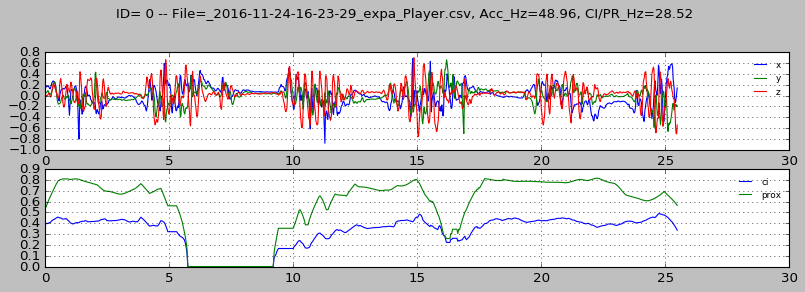

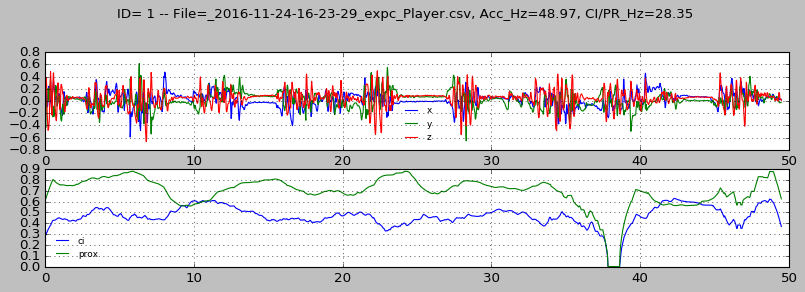

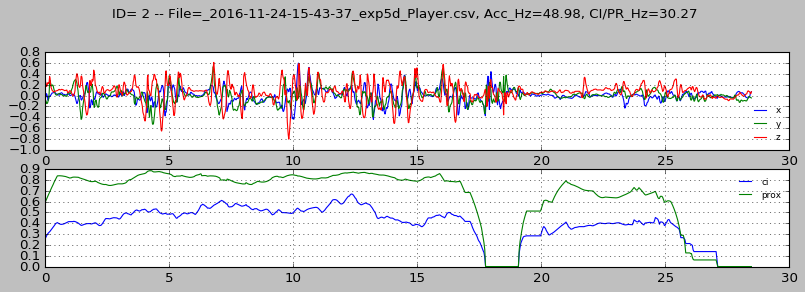

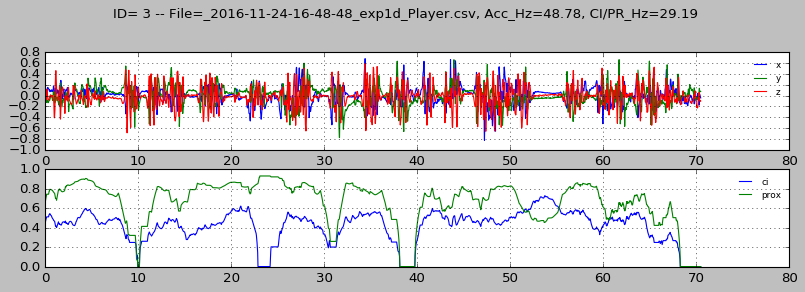

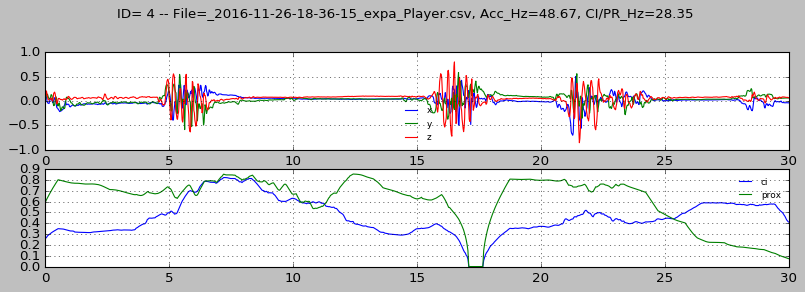

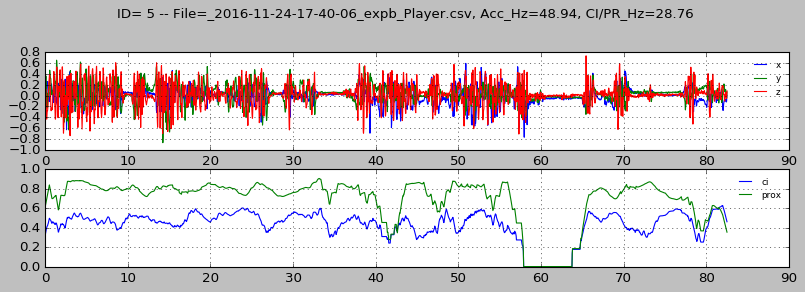

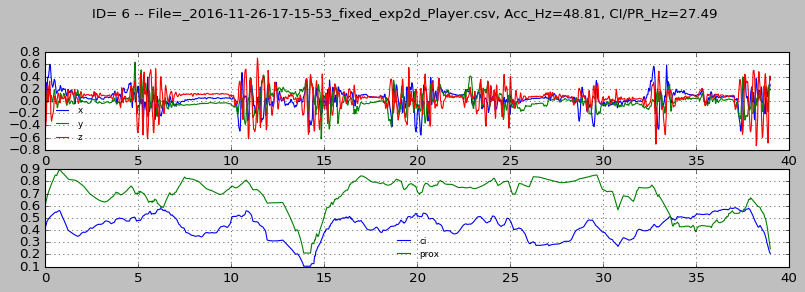

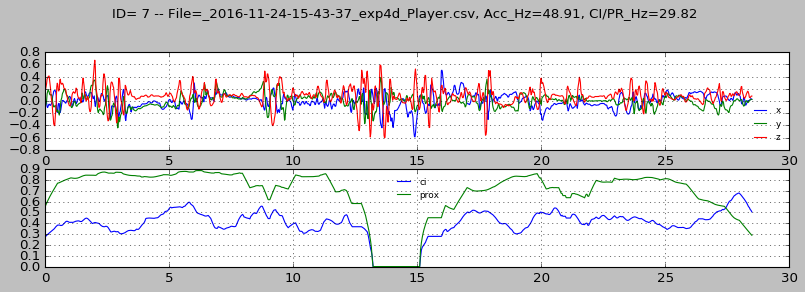

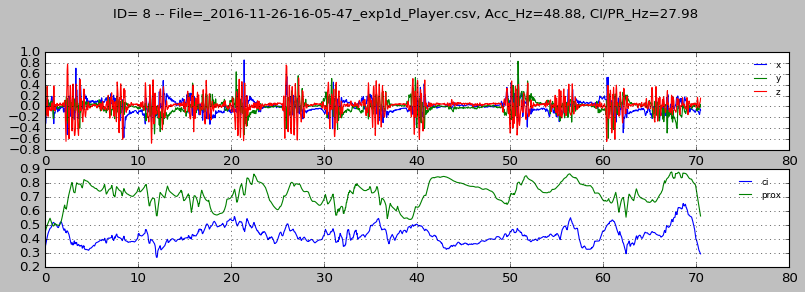

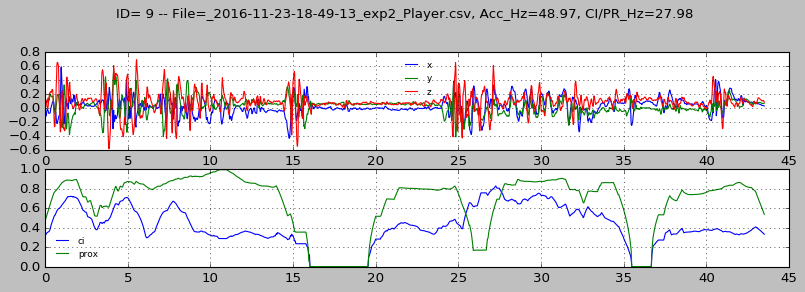

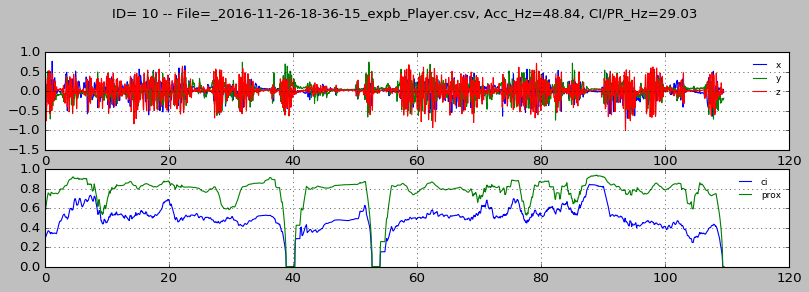

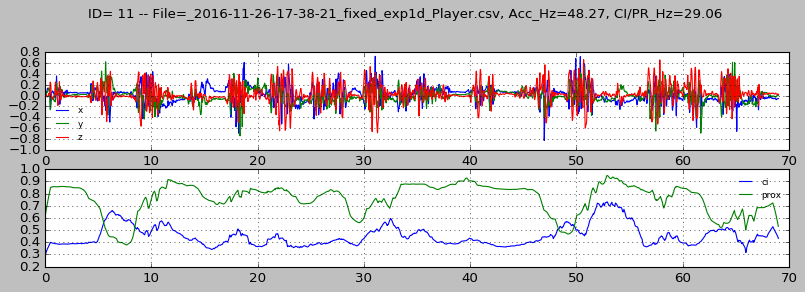

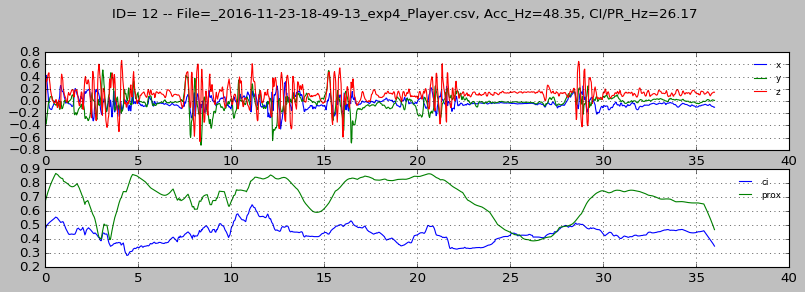

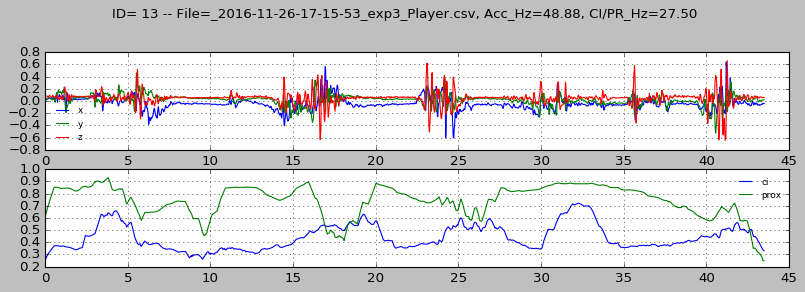

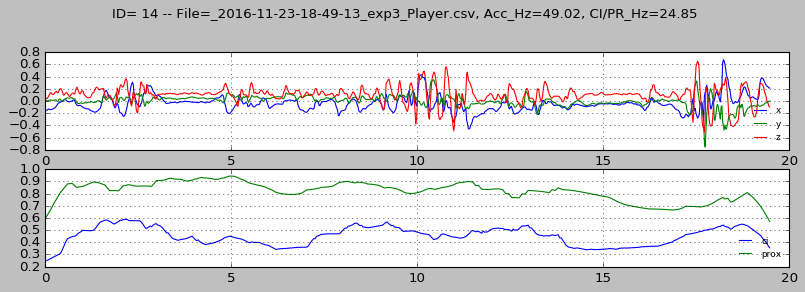

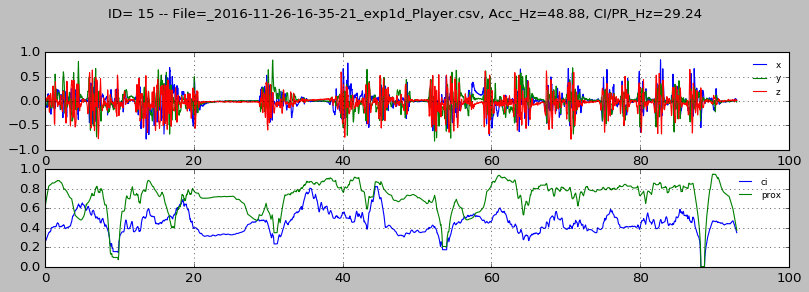

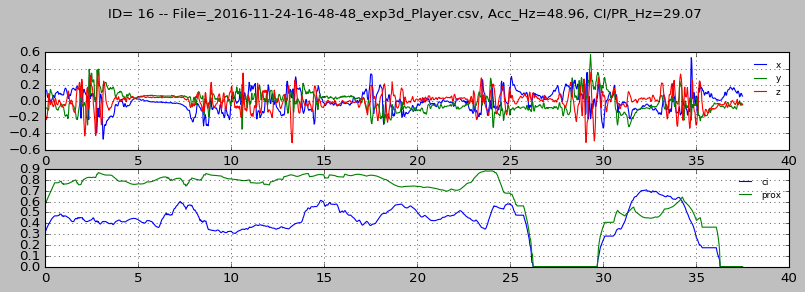

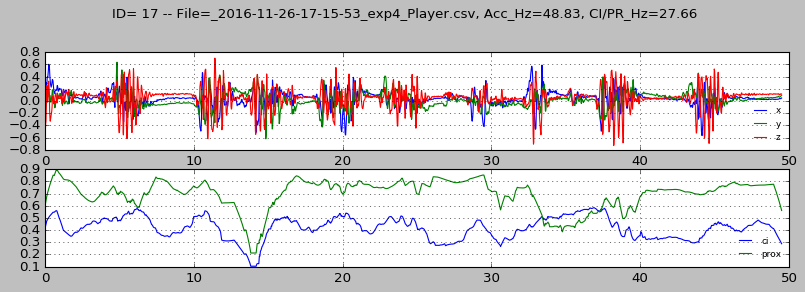

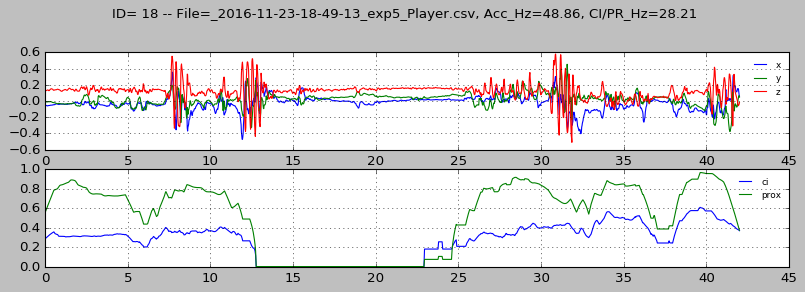

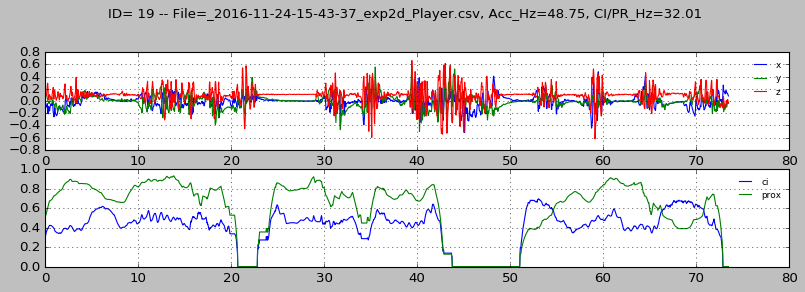

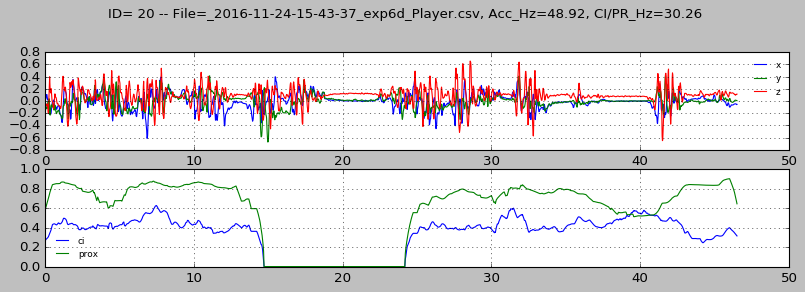

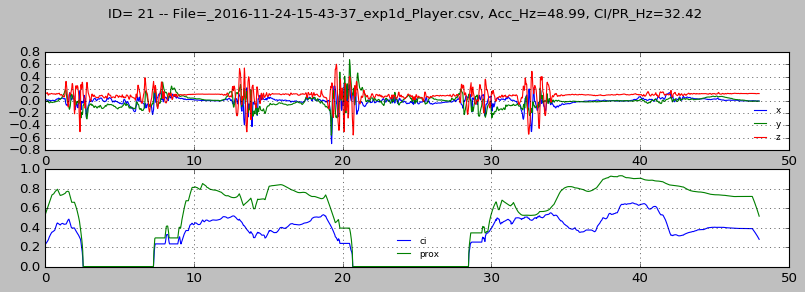

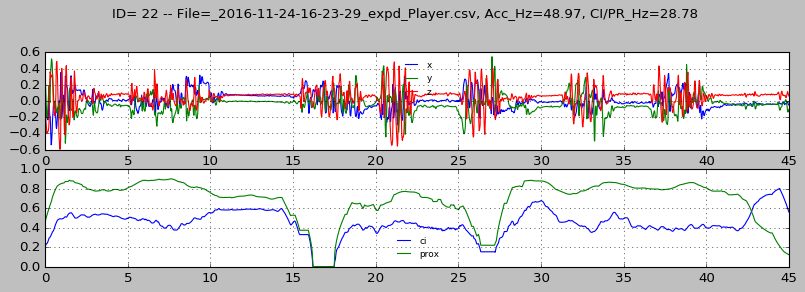

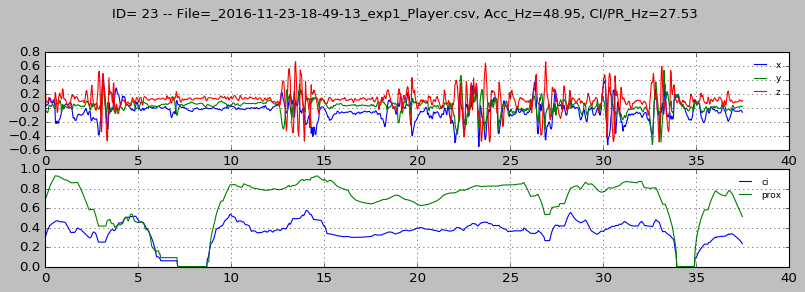

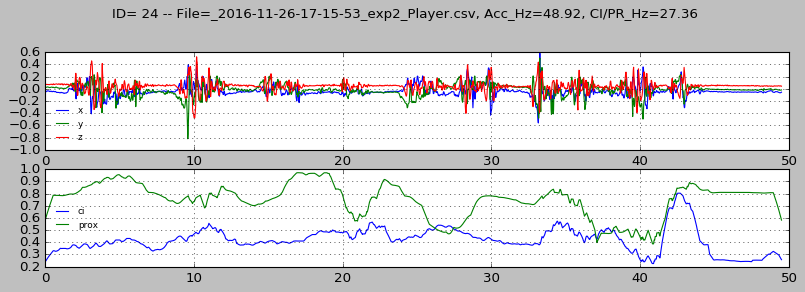

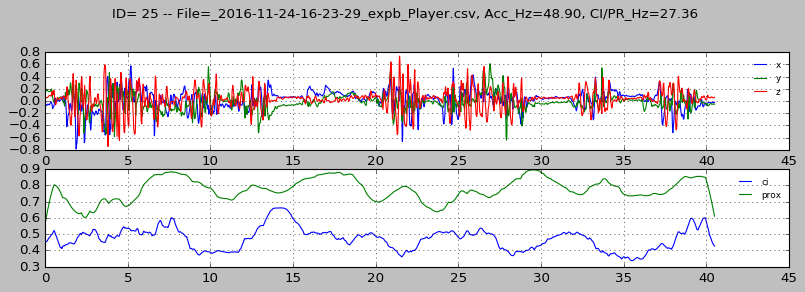

In [13]:
# Because accelerometer and kinect data (ci and proximity) have different frequency, we get them separatedly by
# using the getSegments data_type parameter.

file_names,x_segment_list, y_segment_list, z_segment_list, ci_segment_list, pr_segment_list = getSegments(arm_df,
                                                                                               win_overlap=win_size,#int(win_size/2),
                                                                                               windows_size=win_size,
                                                                                               data_type='all')

## Plotting Segments && Associated Gramian Angular Field

In [14]:
def getGASF(series, gaf_type = 'GASF', rescale = 'Zero'):
    '''Get all GASF from a <list> of segments.'''
    l = []
    for s in series:
        img, _ = serie2GAF.serie2GAF(list(s), GAF_type = gaf_type, rescale_type = rescale) #[(-1,1),(0,1)])
        l.append(img)
    return l

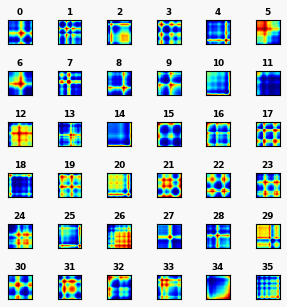

In [15]:
import scipy
import itertools

data_sources = {'x': x_segment_list,
                'y': y_segment_list,
                'z': z_segment_list,
                'ci': ci_segment_list,
                'pr': pr_segment_list,
                'files': file_names}

### GET GASFs FOR ALL DATA_SOURCES
all_gasfs = {}
for src in data_sources.keys():
    gasfs = []
    for seg in data_sources[src]:
        gasfs.append(getGASF(seg))
    all_gasfs[src+"_gasf_list"] = gasfs
    all_gasfs[src+"_all_files_gasfs"] = list(itertools.chain.from_iterable(gasfs))
    
all_gasfs['files'] = [f[1] for f in datasetX]
######################################

### GET GASFs FOR linear combination of axis in the accelerometer
all_acc_gasfs={}
all_acc_gasfs['data'] = []
all_acc_gasfs['Lcombination'] = []
for i in range(len(x_segment_list)):
    gasfs = []
    combs = []
    for x, y, z in zip(x_segment_list[i],y_segment_list[i],z_segment_list[i]):
        comb = 0.25*np.array(x)+0.25*np.array(y)+0.5*np.array(z)
        gasfs.append(getGASF([comb])[0])
        combs.append(comb)
    all_acc_gasfs['data'].append(gasfs)
    all_acc_gasfs['Lcombination'].append(combs)
all_acc_gasfs['files'] = data_sources['files']
all_gasfs["all"] = list(itertools.chain.from_iterable(all_acc_gasfs['data']))
###################
    
# EXAMPLE
FILE = 0                  # which file to look
#DATA = z_segment_list     # which data

#t = []
#for x, y, z in zip(getGASF(x_segment_list[FILE]),getGASF(y_segment_list[FILE]),getGASF(z_segment_list[FILE])):
#    t.append(0.25*x+0.25*y+0.5*z)

gridGAFPlotting(all_acc_gasfs['data'][FILE], fig_size=(4,4))
plt.tight_layout()
plt.show()
#plt.savefig("example_gafs_seg.eps")

new_segs = [0.25*np.array(x)+0.25*np.array(y)+0.5*np.array(z) for x,y,z in zip(x_segment_list[FILE],
                                                                               y_segment_list[FILE],
                                                                               z_segment_list[FILE])]

#FILE = 2
#Fs =  48.98
#N_samps = len(list(itertools.chain.from_iterable(x_segment_list[FILE])))
#t   = np.linspace(0,N_samps*(1/Fs),N_samps) # N_samps*T (#samples x sample period) # is the signal time.
            
#fig = plt.figure(figsize=(7,2))
#fig.patch.set_alpha(0.1)
#plt.plot(t, list(itertools.chain.from_iterable(x_segment_list[FILE])), lw= 2, label='x')
#plt.plot(t, list(itertools.chain.from_iterable(y_segment_list[FILE])), lw= 2, label='y')
#plt.plot(t, list(itertools.chain.from_iterable(z_segment_list[FILE])), lw= 2, label='z')
#plt.xlabel("secs")
#plt.ylabel("acceleration")
#plt.grid()
#plt.xlim([0,max(t)+2])
#plt.xticks(())
#plt.yticks(())

#plt.savefig("example_signal2.png")

#gridPlotting(new_segs, fig_size="", set_axis_off=False)
#gridGAFPlotting(getGASF(DATA[FILE]))

## How can we get the time series back from a GAF image?

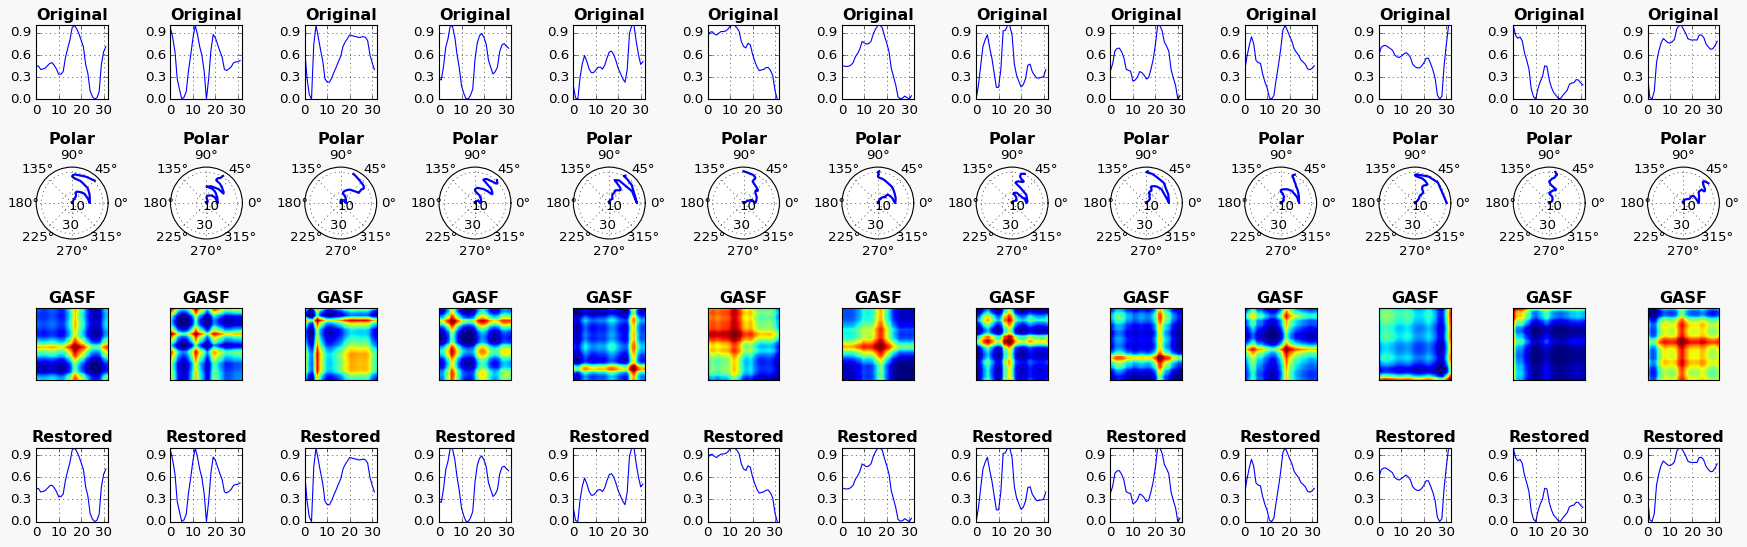

In [16]:
n = 13
offset = 0
fig = plt.figure(figsize=(22, 7))
fig.patch.set_alpha(0.1)
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i+1)
    ax.grid()
    ax.plot(serie2GAF.rescale(new_segs[i+offset]))
    ax.set_title("Original", fontweight="bold")
    ax.set_ylim((0,1))
    ax.set_xlim((0,32))
    ax.set_yticks(np.arange(0,1,0.3))
    ax.set_xticks(range(0,32,10))
   
    
    # plot original segment signal
    ax = plt.subplot(4, n, i+1 + n, projection='polar')
    s = serie2GAF.rescale(new_segs[i+offset])
    ax.plot(np.arccos(s), range(len(s)), lw=2)
    ttl = ax.title
    ttl.set_position([.5, 1.25])
    ax.set_title("Polar", fontweight="bold")
    ax.set_rgrids(range(10,len(s),20), angle=250, fontsize=5)

    # display reconstruction
    ax = plt.subplot(4, n, i+1 + 2*n)
    g = [list(new_segs[i+offset])]
    g = getGASF(g)
    ax.grid()
    ax.imshow(g[0])
    ax.set_title("GASF", fontweight="bold")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(4, n, i+1 + 3*n)
    retrieved = serie2GAF.getSeriesFromGAF(g[0])
    ax.grid()
    ax.plot(retrieved)
    ax.set_title("Restored", fontweight="bold")
    ax.set_ylim((0,1))
    ax.set_xlim((0,32))
    ax.set_yticks(np.arange(0,1,0.3))
    ax.set_xticks(range(0,32,10))
plt.tight_layout()
#plt.savefig('gasfpipeline.eps')

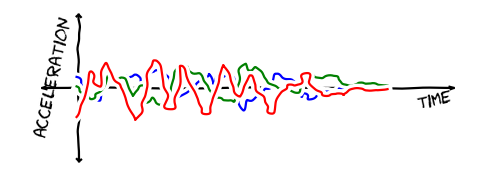

In [17]:
import xkcd
import itertools

np.random.seed(0)
plt.figure(figsize=(6,2))

ax = plt.axes()
f = 3
s = 30

ax.plot(list(itertools.chain.from_iterable(x_segment_list[f][s-4:s])), 'b', lw=1, label='x')
ax.plot(list(itertools.chain.from_iterable(y_segment_list[f][s-4:s])), 'g', lw=1, label='y')
ax.plot(list(itertools.chain.from_iterable(z_segment_list[f][s-4:s])), 'r', lw=1, label='z')

#ax.set_title('Standing still!')
ax.set_xlabel('time')
ax.set_ylabel('acceleration')

ax.set_ylim(-1.0, 1.0)

#ax.legend(loc='upper right')

#XKCDify the axes -- this operates in-place
xkcd.XKCDify(ax, xaxis_loc=0.0, yaxis_loc=1.0, xaxis_arrow='+-', yaxis_arrow='+-', expand_axes=True)

#plt.savefig('running_sig_profile.eps')

In [18]:
##Testing global normalization

#def toZeroOne(x):
#    return np.fromiter((serie2GAF.translateIntervalRange(xi, -1, 1, 0, 1) for xi in x), x.dtype)

#def toMinusOneAndOne(x):
#    return np.fromiter((serie2GAF.translateIntervalRange(xi, 0, 1, -1, 1) for xi in x), x.dtype)


##r =  g[0].reshape((1, np.prod(g[0].shape)))
#r = toZeroOne(g[0].ravel())
#plt.imshow(r.reshape(32,32))
#plt.show()

#r = toMinusOneAndOne(r)
#r = np.reshape(r, (32,32))
#print g[0].shape
#assert np.array_equal(r,g[0])


### Saving mat file

In [19]:
#import scipy.io as sio


#sio.savemat('segments.mat', {'x_list': x_segment_list,
#                              'y_list': y_segment_list,
#                              'z_list': z_segment_list,
#                              'ci_list': ci_segment_list,
#                              'pr_list': pr_segment_list,
#                              'files': [f[1] for f in datasetX]})

### Saving GASFs to mat

In [20]:
#import scipy.io as sio
#sio.savemat('gasfs.mat', all_gasfs)

## Exporting all GAF data

In [21]:
import pickle

#print "#Games: {}".format(len(ci_segment_list))

DATA = all_acc_gasfs['Lcombination']

ALL_GAF = []

#for i in range(len(DATA)):
#    for s in DATA[i]:
#        #rescaled_sample = serie2GAF.rescale(list(s))
#        img, _ = serie2GAF.serie2GAF(list(s), GAF_type = 'GASF', rescale_type = 'Zero')
#        ALL_GAF.append(img)

#print len(all_gasfs["all"])
#for i, img in enumerate(all_gasfs["all"]):
    #img_01 = toZeroOne(img.ravel())
    #img_11 = toMinusOneAndOne(img_01)
    
    #try:
    #    assert np.array_equal(np.reshape(img_11, (32,32)),img)
    #except Exception as e:
    #    print i
    #    print img
    
#    ALL_GAF.append(np.ones_like(img)+img)
#        #print img_norm
ALL_GAF = all_gasfs["all"]
print len(ALL_GAF)

#print np.array(images).shape
# write python dict to a file
#output = open('all_ci_game_28x28.pkl', 'wb')
#pickle.dump(np.array(images), output)
#output.close()

1984


## Data preparation

In [22]:
N_FILES_USED_FOR_TRAINNING = 23

## getting training files segments
n_train_segments = sum([len(DATA[i]) for i in range(len(DATA[:N_FILES_USED_FOR_TRAINNING]))])
print "# Train segments: {}".format(n_train_segments)

data_train = ALL_GAF[:n_train_segments]
data_test = ALL_GAF[n_train_segments:]

data_train = np.array(data_train).reshape(len(data_train), -1)
data_test = np.array(data_test).reshape(len(data_test), -1)

print "Train data shape: {}".format(data_train.shape)
print "Test data shape: {}".format(data_test.shape)

num_test_images = len(data_test)
num_train_images = len(data_train)

# Train segments: 1791
Train data shape: (1791, 1024)
Test data shape: (193, 1024)


## Convolutional Autoencoder

In [23]:
import keras
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation
from keras.models import Model
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model
from keras.layers import Input, Dense, Dropout
from keras.utils import np_utils
import numpy as np
import keras 
from keras.callbacks import ReduceLROnPlateau
import pandas as pd

Using TensorFlow backend.


In [24]:
x_train, x_test = data_train, data_test
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
autoencoder = None

def  create_model(input_shape=x_train.shape[1:]):
    input_img = Input(input_shape)
    encoded= Dropout(0.1)(input_img)
    encoded = Dense(256, activation='tanh')(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(64, activation='tanh')(encoded)
    
    decoded = Dropout(0.2)(encoded)
    decoded = Dense(256, activation = 'tanh')(decoded)
    decoded = Dropout(0.3)(decoded)
    decoded = Dense(1024, activation='linear')(decoded)
    return Model(input_img, decoded)

def train():
    global autoencoder
    autoencoder = create_model(input_shape=x_train.shape[1:])
    optimizer = keras.optimizers.Adadelta()    
    autoencoder.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    plot_model(autoencoder, to_file='model.png')
    autoencoder.summary()
    autoencoder.fit(x_train, x_train,
                    epochs=2000,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [25]:
#train()

In [26]:
model_name = './autoencoder_models/modelv6-final-dense-layers-64.h5'

### Save model

In [27]:
#import h5py
#autoencoder.save_weights(model_name)
#autoencoder.summary()

## Load Saved Autoencoder

In [28]:
autoencoder = create_model()
autoencoder.load_weights(model_name)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16640     
__________

### Ploting reconstruction

../code/serie2GAF.py:43: RuntimeWarning: invalid value encountered in sqrt
  retrieved.append(np.sqrt((gaf_image[i][i] + 1) / 2))


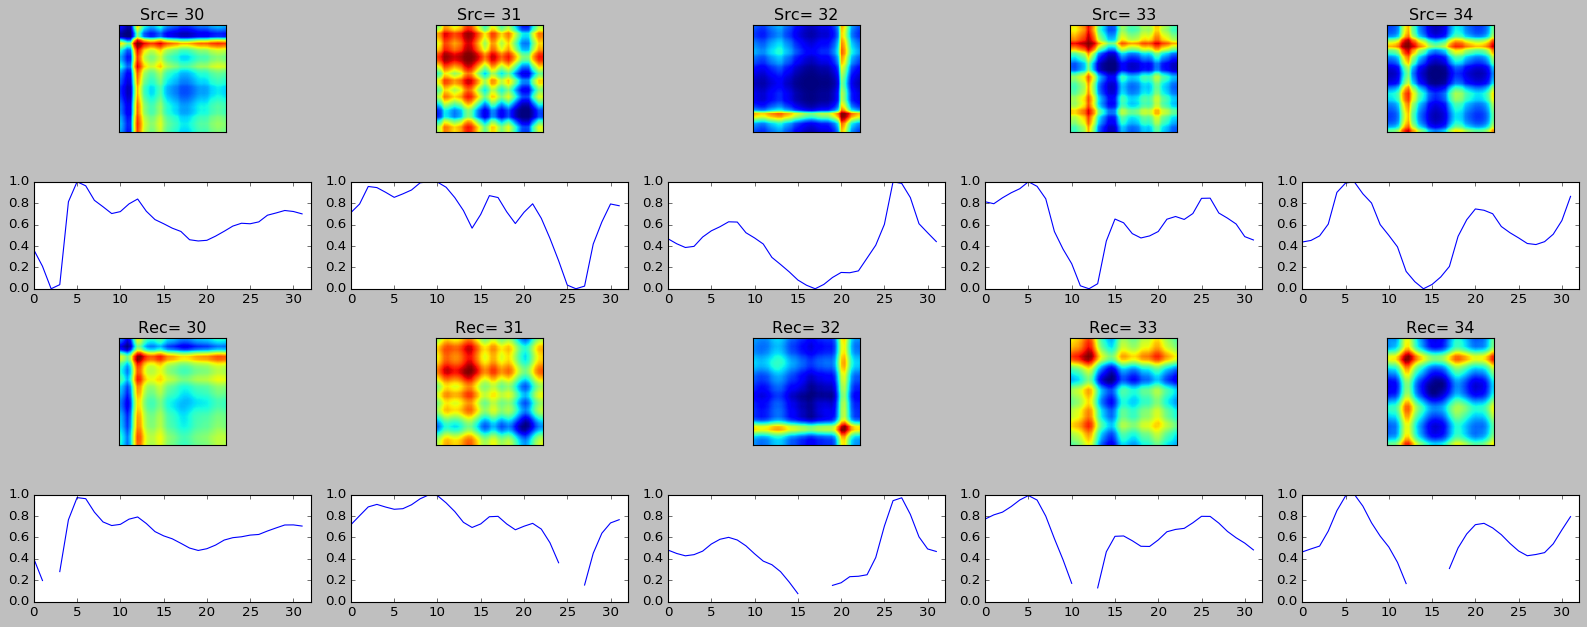

In [29]:
reload(serie2GAF)
decoded_imgs = autoencoder.predict(x_test)

n = 5
offset = 30
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i+1)
    plt.imshow(x_test[i+offset].reshape(32, 32))
    ax.set_title("Src= {}".format(i+offset))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(4, n, i+1 + n)
    retrieved = serie2GAF.getSeriesFromGAF(x_test[i+offset].reshape((32,32)))
    ax.plot(retrieved)
    ax.set_ylim((0,1))
    ax.set_xlim((0,32))

    # display reconstruction
    ax = plt.subplot(4, n, i+1 + 2*n)
    plt.imshow(decoded_imgs[i+offset].reshape(32, 32))
    ax.set_title("Rec= {}".format(i+offset))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(4, n, i+1 + 3*n)
    retrieved = serie2GAF.getSeriesFromGAF(decoded_imgs[i+offset].reshape((32,32)))
    
    ax.plot(retrieved)
    ax.set_ylim((0,1))
    ax.set_xlim((0,32))

plt.tight_layout()
plt.show()

### Filters

In [30]:
import keras.backend as K


def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


In [31]:
a = get_activations(autoencoder, x_test[30:40], print_shape_only=True)  # with just one sample.

----- activations -----
(10, 1024)
(10, 1024)
(10, 256)
(10, 256)
(10, 64)
(10, 64)
(10, 256)
(10, 256)
(10, 1024)


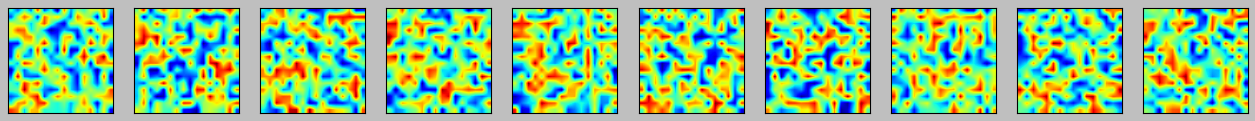

In [32]:
plt.figure(figsize=(20, 4))
layer = a[3]
for i in range(len(layer)):
    # display original
    ax = plt.subplot(1, layer.shape[0], i+1)
    plt.imshow(layer[i].reshape(int(np.sqrt(layer.shape[1])), int(np.sqrt(layer.shape[1]))))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Latent Dirichlet Allocation¶

In [33]:
import numpy as np
#import cv2
import json
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from time import time

In [34]:
#print "OpenCV version: {}".format(cv2.__version__)

In [35]:
from keras.models import Sequential

encoder = Sequential()
for layer in autoencoder.layers[:5]:
  encoder.add(layer)

# this model maps an input to its encoded representation
#encoder = m.(Input(shape=x_train.shape[1:]), encoded)

In [41]:
print x_train.shape[0] + x_test.shape[0]
encoded_imgs = encoder.predict(np.vstack((x_train, x_test))) ### we consider all documents

1984


Stacked features: (1984, 64)
K-means objective: 6750.96
elapsed time: 0.4319 sec


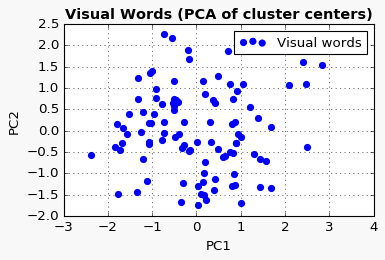

In [44]:
print "Stacked features: {}".format(encoded_imgs.shape)

# Cluster images into a dictionary
dictionary_size = 100

kmeans = MiniBatchKMeans(n_clusters=dictionary_size,
                         init='k-means++',
                         batch_size=5000,
                         random_state=0,
                         verbose=0)
tic = time()
kmeans.fit(encoded_imgs)
toc = time()
kmeans.get_params()

print "K-means objective: %.2f" % kmeans.inertia_
print "elapsed time: %.4f sec" % (toc - tic)

# PCA plot of kmeans_cluster centers
pca = PCA(n_components=2)
visual_words = pca.fit_transform(kmeans.cluster_centers_)

fig = plt.figure(figsize=(5, 3))
fig.patch.set_alpha(0.1)

plt.scatter(visual_words[:, 0], visual_words[:, 1], color='b', marker='o', lw=2.0, label='Visual words')
plt.title("Visual Words (PCA of cluster centers)", fontsize=13, fontweight="bold")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(fontsize=12)
plt.show()
#plt.savefig(model_name.split('.')[0]+'visual_words'+'.eps')

## Parameter selection

In [43]:
from collections import Counter

results = []

for d_size in range(50,1000,200):
    print "Running for param {}".format(d_size)
    dictionary_size = d_size

    kmeans = MiniBatchKMeans(n_clusters=dictionary_size,
                             init='k-means++',
                             batch_size=5000,
                             random_state=0,
                             verbose=0)
    #tic = time()
    kmeans.fit(encoded_imgs)
    
    doc_words = []

    for s in encoded_imgs:
        doc_words.append(list(kmeans.predict(s.reshape(1, -1)))[0])

    ## Getting segments per documents back.
    n_segments_per_doc = [len(DATA[i]) for i in range(len(DATA[:N_FILES_USED_FOR_TRAINNING]))]

    docs = []

    index = 0
    for i, n_seg in enumerate(n_segments_per_doc):
        docs.append(doc_words[index:index+n_seg])
        index += n_seg
        assert len(docs[i]) == n_seg
        
    d = Counter(itertools.chain.from_iterable(docs))
    results.append([v[1] for v in d.most_common()])

Running for param 50
Running for param 250
Running for param 450
Running for param 650
Running for param 850


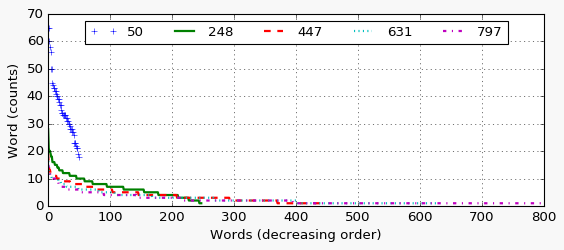

In [45]:
from collections import Counter

d = Counter(itertools.chain.from_iterable(docs))

markers_array = ['+', '-', '--', ':', '-.']

fig = plt.figure(figsize=(8, 3))
fig.patch.set_alpha(0.1)

for k,i in enumerate(results):
    plt.plot(i,markers_array[k], label=str(len(i)), lw=2)
plt.ylabel('Word (counts)', fontsize=12)
plt.xlabel('Words (decreasing order)', fontsize=12)
plt.legend(fontsize=12, loc='upper center', ncol=5)
plt.grid()
#plt.savefig(model_name.split('.')[0]+'word_dist'+'.eps')

### Get docs && create histogram of labels for each image = term-document matrix

0 - # windows in _2016-11-24-16-23-29_expa_Player.csv: 39 	 Splitted into: 1 docs
Saving doc split: _2016-11-24-16-23-29_expa_0.mp4
1 - # windows in _2016-11-24-16-23-29_expc_Player.csv: 75 	 Splitted into: 3 docs
Saving doc split: _2016-11-24-16-23-29_expc_0.mp4
Saving doc split: _2016-11-24-16-23-29_expc_1.mp4
Saving doc split: _2016-11-24-16-23-29_expc_2.mp4
2 - # windows in _2016-11-24-15-43-37_exp5d_Player.csv: 43 	 Splitted into: 1 docs
Saving doc split: _2016-11-24-15-43-37_exp5d_0.mp4
3 - # windows in _2016-11-24-16-48-48_exp1d_Player.csv: 107 	 Splitted into: 4 docs
Saving doc split: _2016-11-24-16-48-48_exp1d_0.mp4
Saving doc split: _2016-11-24-16-48-48_exp1d_1.mp4
Saving doc split: _2016-11-24-16-48-48_exp1d_2.mp4
Saving doc split: _2016-11-24-16-48-48_exp1d_3.mp4
4 - # windows in _2016-11-26-18-36-15_expa_Player.csv: 45 	 Splitted into: 1 docs
Saving doc split: _2016-11-26-18-36-15_expa_0.mp4
5 - # windows in _2016-11-24-17-40-06_expb_Player.csv: 126 	 Splitted into: 5 docs

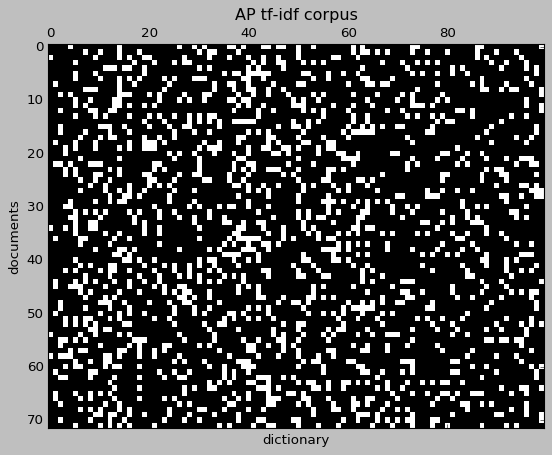

In [48]:
from collections import defaultdict
doc_words = []

for s in encoded_imgs:
    doc_words.append(list(kmeans.predict(s.reshape(1, -1)))[0])

## Getting segments per documents back.
n_segments_per_doc = [len(DATA[i]) for i in range(len(DATA))]#[:N_FILES_USED_FOR_TRAINNING]))]

docs = []
docs_names = []

partition_book_list = defaultdict(int)       ### Keeps a record of how many segments a file generated

index = 0
for i, n_seg in enumerate(n_segments_per_doc):

    n_win_per_doc = int(sample_size/win_size)
    d_words = []
    d_all_words = doc_words[index:index+n_seg]
    print "{} - # windows in {}: {} \t Splitted into: {} docs".format(i,all_acc_gasfs['files'][i],
                                                   len(d_all_words),
                                                   int(len(d_all_words)/n_win_per_doc))
    
    partition_book_list[all_acc_gasfs['files'][i]] = int(len(d_all_words)/n_win_per_doc)
    
    for k in [d_all_words[j:j+n_win_per_doc] for j in range(0,len(d_all_words), n_win_per_doc)]:
        if len(k) == n_win_per_doc:
            d_words.append(k)
    
    for num, l in enumerate(d_words):
        doc_split_name = all_acc_gasfs['files'][i].split('_Player.csv')[0]+"_"+str(num)+'.mp4'
        docs_names.append(doc_split_name)
        print "Saving doc split: {}".format(doc_split_name) 
        docs.append(l)

    index += n_seg
    assert len(d_words) == int(len(d_all_words)/n_win_per_doc)

num_train_games = len(docs)

A = np.zeros((dictionary_size, num_train_games))
ii = 0
jj = 0

for doc_idx in range(num_train_games):
    A[:, doc_idx], bins = np.histogram(docs[doc_idx], bins=range(dictionary_size+1))

plt.spy(A.T, cmap="gray")
plt.gca().set_aspect('auto')
plt.title('AP tf-idf corpus')
plt.xlabel('dictionary')
plt.ylabel('documents')    
plt.show()

## Fit LDA topic model based on tf-idf of term-document matrix

Fitting LDA model...
Elapsed time: 0.5227 sec
LDA params
{
    "learning_offset": 10.0, 
    "n_jobs": 1, 
    "topic_word_prior": null, 
    "perp_tol": 0.1, 
    "evaluate_every": -1, 
    "max_iter": 50, 
    "mean_change_tol": 0.001, 
    "batch_size": 128, 
    "max_doc_update_iter": 100, 
    "learning_decay": 0.7, 
    "n_components": 10, 
    "random_state": 0, 
    "doc_topic_prior": null, 
    "n_topics": null, 
    "total_samples": 1000000.0, 
    "learning_method": "batch", 
    "verbose": 0
}
Number of EM iter: 51
Number of dataset sweeps: 50


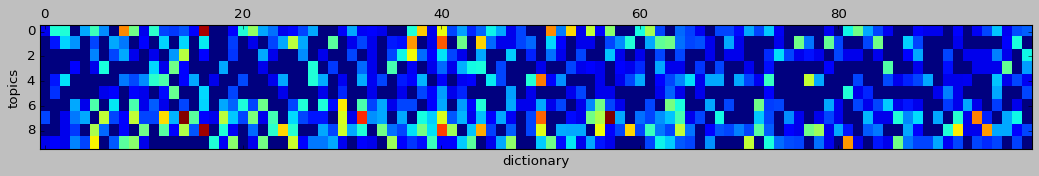

In [50]:
num_features = dictionary_size
num_topics = 10      # fixed for LDA

# Fit LDA model
print "Fitting LDA model..."
lda_vb = LatentDirichletAllocation(n_components=num_topics,
                                   max_iter=50,
                                   learning_method='batch',
                                   random_state=0,
                                   n_jobs=1)

tic = time()
lda_vb.fit(A.T)         # online VB
toc = time()

print "Elapsed time: %.4f sec" % (toc - tic)
print "LDA params"
print json.dumps(lda_vb.get_params(), indent=4)

print "Number of EM iter: %d" % lda_vb.n_batch_iter_
print "Number of dataset sweeps: %d" % lda_vb.n_iter_

# topic matrix W: K x V
# components[i,j]: topic i, word j
# note: here topics correspond to label clusters
topics = lda_vb.components_

plt.matshow(topics, cmap=plt.get_cmap("jet"))
plt.gca().set_aspect('auto')
#plt.title('learned topic matrix')
plt.ylabel('topics')
plt.xlabel('dictionary')
plt.show()


### Topic proportions matrix: D x K

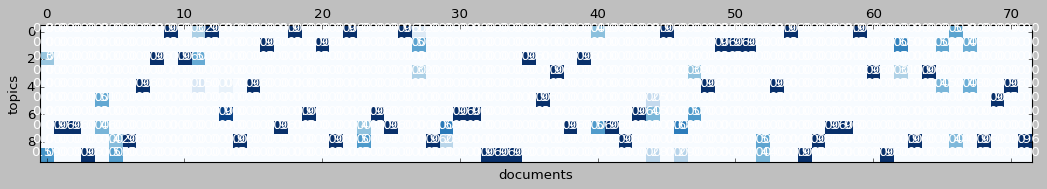

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#plot_colormap(matrix, cmap_fmt= "jet", normalize = True, title='topic proportions', xlabel='topics',
#    ylabel='documents', f_size=(18,18), colorbar_off=True)
    
H = lda_vb.transform(A.T)
plot_colormap(H.T, cmap_fmt='Blues', xlabel='documents', ylabel='topics', title="", f_size=(4,4))

## Similarity matrix

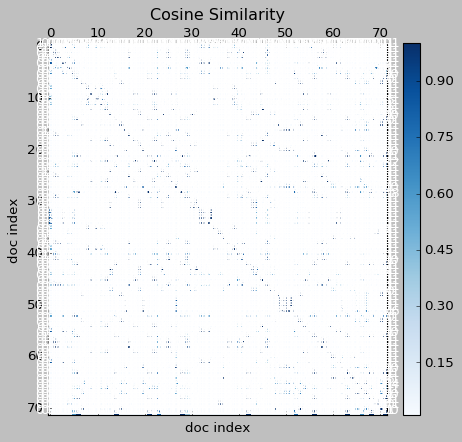

In [116]:
# Retrieve H_train document that's closest in cosine similarity for each H_test
# Use cosine similarity for image retrieval

#Kxy = cosine_similarity(H[:10,:], H[:10,:])
Kxy = cosine_similarity(H, H)
#knn_test = np.argmin(Kxy, axis=1)

plot_colormap(Kxy, cmap_fmt='Blues', title='Cosine Similarity',
              xlabel='doc index', ylabel='doc index', colorbar_off=False)
# plt.savefig('./figures/cosine_similarity.png')

### Get the list of files and also the list of files with last video segment less than 15secs

In [140]:
m = get_human_norm_sim_matrix(docs_names, docs)
print 
print "MSE: {}".format(get_mse(H, m))

Filenames with less than 15secs in the last window:
['_2016-11-23-18-49-13_exp1_Player.csv', '_2016-11-24-16-23-29_expa_Player.csv', '_2016-11-26-16-49-44_exp1d_Player.csv', '_2016-11-23-18-49-13_exp5_Player.csv', '_2016-11-26-16-05-47_exp1d_Player.csv', '_2016-11-24-15-43-37_exp2d_Player.csv', '_2016-11-26-15-42-51_exp1d_Player.csv', '_2016-11-24-16-48-48_exp3d_Player.csv', '_2016-11-26-17-38-21_fixed_exp1d_Player.csv']
Failed assertion in _2016-11-26-15-42-51_exp1d_Player.csv!
Failed assertion in _2016-11-24-17-15-38_expb_Player.csv!
Failed assertion in _2016-11-26-17-15-53_fixed_exp1d_Player.csv!
Failed assertion in _2016-11-23-18-49-13_exp2_Player.csv!
Failed assertion in _2016-11-24-16-23-29_expd_Player.csv!
Failed assertion in _2016-11-24-15-43-37_exp5d_Player.csv!
Failed assertion in _2016-11-24-15-43-37_exp3d_Player.csv!
Failed assertion in _2016-11-24-17-15-38_expc_Player.csv!
Failed assertion in _2016-11-26-16-49-44_exp1d_Player.csv!
Failed assertion in _2016-11-26-18-36-15_e

### Test documents

In [ ]:
# test_encoded_imgs = encoder.predict(x_test)

# test_doc_words = []

# for s in test_encoded_imgs:
#     test_doc_words.append(list(kmeans.predict(s.reshape(1, -1)))[0])

# ## Getting segments per documents back.
# n_segments_per_test_doc = [len(DATA[i+N_FILES_USED_FOR_TRAINNING]) for i in range(len(DATA[N_FILES_USED_FOR_TRAINNING:]))]

# test_docs = []
# test_docs_names = []

# #index = 0
# #for i, n_seg in enumerate(n_segments_per_test_doc):
# #    test_docs.append(test_doc_words[index:index+n_seg])
# #    index += n_seg
# #    assert len(test_docs[i]) == n_seg
# #num_test_games = len(test_docs)

# index = 0
# for i, n_seg in enumerate(n_segments_per_test_doc):

#     n_win_per_doc = int(sample_size/win_size)
#     d_words = []
#     d_all_words = test_doc_words[index:index+n_seg]
#     print "{} - # windows in {}: {} \t Splitted into: {} docs".format(i, all_acc_gasfs['files'][N_FILES_USED_FOR_TRAINNING+i],
#                                                                       len(d_all_words),
#                                                                       int(len(d_all_words)/n_win_per_doc))
    
#     partition_book_list[all_acc_gasfs['files'][N_FILES_USED_FOR_TRAINNING+i]] = int(len(d_all_words)/n_win_per_doc)
    
#     for k in [d_all_words[j:j+n_win_per_doc] for j in range(0,len(d_all_words), n_win_per_doc)]:
#         if len(k) == n_win_per_doc:
#             d_words.append(k)
    
#     for num, l in enumerate(d_words):
#         doc_split_name = all_acc_gasfs['files'][N_FILES_USED_FOR_TRAINNING+i].split('_Player.csv')[0]+"_"+str(num)+'.mp4'
#         test_docs_names.append(doc_split_name)
#         print "Saving doc split: {}".format(doc_split_name) 
#         test_docs.append(l)

#     index += n_seg
#     assert len(d_words) == int(len(d_all_words)/n_win_per_doc)
# num_test_games = len(test_docs)

In [54]:
# # Assign des_test_tot to one of kmeans cluster centers
# # Use 128-dimensional kd-tree to search for nearest neighbors
# kdt = KDTree(kmeans.cluster_centers_)

# Q = test_encoded_imgs                        # query
# kdt_dist, kdt_idx = kdt.query(Q, k=1)   # knn
# test_labels = kdt_idx                   # knn = 1 labels

# # Form A_test matrix from test_labels
# # Histogram of labels for each image: term-document matrix
# A_test = np.zeros((dictionary_size, num_test_games))
# for doc_idx in range(num_test_games):
#     A_test[:, doc_idx], bins = np.histogram(test_docs[doc_idx], bins=range(dictionary_size+1))

# plt.spy(A_test.T, cmap="gray")
# plt.gca().set_aspect('auto')
# plt.title('AP tf-idf corpus')
# plt.xlabel('dictionary')
# plt.ylabel('documents')
# plt.show()                 

# # Use fit transform on A_test for already trained LDA to get the H_test matrix
# # topic proportions matrix: D x K
# # note: np.sum(H, axis=1) is not 1
# H_test = lda_vb.transform(A_test.T)    

# plot_colormap(H_test, cmap_fmt='Blues')

# # plt.savefig('./figures/proportions_test.png')

# # Retrieve H_train document that's closest in cosine similarity for each H_test
# # Use cosine similarity for image retrieval
# Kxy = cosine_similarity(H_test, H)
# knn_test = np.argmin(Kxy, axis=1)

# plot_colormap(Kxy, cmap_fmt='Blues', title='Cosine Similarity', xlabel='train data', ylabel='test data')
# # plt.savefig('./figures/cosine_similarity.png')

# # Display knn images (docId is an image)
# #rnd_idx = np.arange(num_test_images)
# #np.random.shuffle(rnd_idx)
# #images = data_test[rnd_idx[0:16], :].reshape(16, win_size, win_size)
# #plot_images(4, 4, images)
# #images_knn = data_train[knn_test[rnd_idx[0:16]], :].reshape(16, win_size, win_size)
# #plot_images(4, 4, images_knn)

## Word frequency analisys

## Getting decoder

In [55]:
# retrieve the decoder layers and apply to each prev layer
encoded_input = Input(shape=(64,))

num_decoder_layers = 4
decoder_layer = encoded_input
for i in range(-num_decoder_layers, 0):
    decoder_layer = autoencoder.layers[i](decoder_layer)

# create the decoder model
decoder = Model(encoded_input, decoder_layer)

In [56]:
from collections import Counter
c = Counter(itertools.chain.from_iterable(docs))

top_30 = [i[0] for i in c.most_common(30)]
print c.most_common(30)

[(40, 44), (16, 33), (14, 32), (44, 31), (50, 30), (37, 28), (64, 28), (5, 27), (32, 27), (57, 26), (9, 25), (12, 25), (38, 25), (30, 24), (42, 24), (63, 24), (8, 23), (25, 23), (56, 23), (62, 23), (73, 22), (51, 21), (47, 20), (96, 20), (13, 19), (19, 19), (55, 19), (61, 19), (22, 18), (39, 18)]


(30, 64)


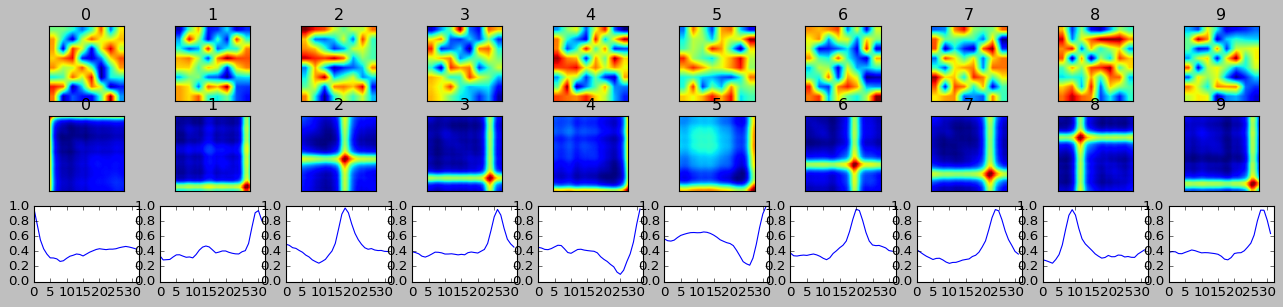

In [58]:
top_30_c_centers = []

for i in top_30:
    top_30_c_centers.append(kmeans.cluster_centers_[i])
    
    
top_30_c_centers = np.array(top_30_c_centers)

print top_30_c_centers.shape

top_30_c_centers = top_30_c_centers.reshape((len(top_30_c_centers), np.prod((64,))))

res = decoder.predict(top_30_c_centers)

n = 10
offset = 0
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(top_30_c_centers[i+offset].reshape(8, 8))
    #plt.gray()
    ax.set_title(i+offset)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display GASF reconstruction
    ax = plt.subplot(3, n, i+1 + n)
    plt.imshow(res[i+offset].reshape(32, 32))
    #plt.gray()
    ax.set_title(i+offset)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display time series reconstruction
    ax = plt.subplot(3, n, i+1 + 2*n)
    retrieved = serie2GAF.getSeriesFromGAF(res[i+offset].reshape((32,32)))
    ax.plot(retrieved)
    ax.set_ylim((0,1))
    ax.set_xlim((0,32))
plt.show()

## Reconstruction

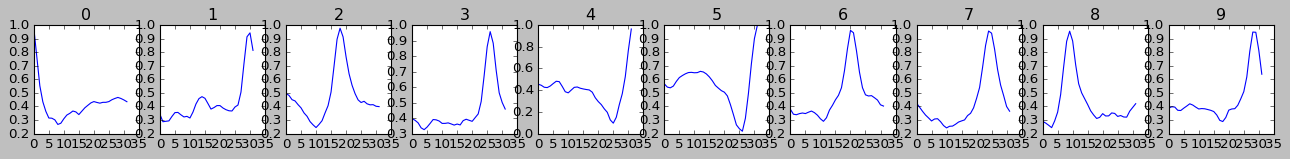

In [59]:
n = 10
offset = 0
plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    ax = plt.subplot(n, n, i+1)
    retrieved = serie2GAF.getSeriesFromGAF(res[i+offset].reshape((32,32)))
    ax.plot(retrieved)
    #plt.gray()
    ax.set_title(i+offset)
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.show()